In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '/Users/mrahimi/Kaggle/module/')
import Plot
import xgb
pl = Plot.Plot()
#import sql2pd

In [4]:
import lightgbm as lgb
import pandas as pd
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

color = sns.color_palette()

class LGB(object):
    def __init__(self, num_boost_round=10, objective=None, metric='None', feval=None, fobj=None, **kwargs):
        self.clf = None
        self.grid_params = None
        self.result = None
        self.grid_list = []
        self.feval = feval
        self.fobj = fobj
        self.num_boost_round = num_boost_round
        self.params = kwargs
        if not fobj:
            if objective:
                print("Built a LightGBM with defiend objective function")
                self.params.update({'boosting_type': 'gbdt', 'objective' : objective, 'metric' : metric})               
            else:
                print("Built a LightGBM with default objective")
                self.params.update({'boosting_type': 'gbdt', 'objective' : 'regression_l2', 'metric' : 'l1'})
            
        print(self.params)
        
    def set_params(self, print_out=True, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        self.params.update(params)
        if print_out:
            print(self.params)
            
    def set_params_scores(self, dt, N=1):
        print(self.params)
        params = dt.iloc[N].to_dict()
        if 'score' in params:
            del params['score']
        if 'iterations' in params:
            self.num_boost_round = params.pop('iterations') + 100
        self.params.update(params)
        print(self.params)
        
    def set_params_dic(self, dic):
        if 'num_boost_round' in dic:
            self.num_boost_round = dic.pop('num_boost_round')
        self.params.update(dic)
        print(self.params)
        
    def fit(self, X, y, num_boost_round=None, categorical=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y, categorical_feature=categorical)
        self.clf = lgb.train(params=self.params, train_set=dtrain, num_boost_round=num_boost_round)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def get_params(self, deep=True):
        return self.params

    def get_importance(self):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val
        return importance

    def plot_importance(self, N = 10):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val

        import operator
        importance = sorted(importance.items(), key=operator.itemgetter(1))

        importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        importance_df['fscore'] = importance_df['fscore'] / importance_df['fscore'].sum()

        plt.figure()
        importance_df[-N:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
        plt.title('XGBoost Feature Importance')
        plt.xlabel('relative importance')
        plt.ylabel('')
        plt.show()
    
    def fit_eval(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 categorical=None, print_out=False):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y, categorical_feature=categorical)
        dtest = lgb.Dataset(X_test, y_test, categorical_feature=categorical, reference=dtrain)
        
        if self.feval == None:
            self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        else:
            self.params.update({'metric': 'None'})
            self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
#                             feval = self.evalerror, 
                             early_stopping_rounds = early_stopping)

        if print_out:
            print("Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score['valid'])
            return
        else:
            return self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
        
    def fit_cv(self, X, y, cv, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 print_out=False):
        
        num_boost_round = num_boost_round or self.num_boost_round
        scores = []
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            dtrain = lgb.Dataset(X[train_index], label=y[train_index])
            dtest = lgb.Dataset(X[test_index], label=y[test_index])

            if self.feval == None:
                self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
            else:
                self.params.update({'metric': 'None'})
                self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
#                             feval = self.evalerror, 
                             early_stopping_rounds = early_stopping)
            
            scores.append(self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]])
            
            if print_out:
                print("Kfold: ", i, "Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score['valid'])

        if not print_out:
            return np.mean(scores)

        
    def grid(self, keys, comb, it=0):
        if len(keys) == it:
            return

        for x in self.grid_params[keys[it]]:
            comb.append(x)
            self.grid(keys, comb, it+1)
            if len(comb) == len(keys):
                self.grid_list.append(comb[:])
            comb.pop()
    
    def make_grid(self, **kwargs):
        self.grid_list = []
        self.grid_params = kwargs
        print(self.params)
        print(self.grid_params)
        self.grid(list(self.grid_params.keys()), [])
        print("Number of iteration for Optimization: ", len(self.grid_list))
        
    def optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, 
                     early_stopping = 2, categorical=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y, categorical_feature=categorical, free_raw_data=False)
        dtest = lgb.Dataset(X_test, y_test, categorical_feature=categorical, reference=dtrain, free_raw_data=False)

        col = list(self.grid_params.keys()) + ['iterations', 'score']
        self.result = pd.DataFrame(columns=col)

        for i in tqdm(range(len(self.grid_list))):
            temp = {}
            for j, key in enumerate(self.grid_params.keys()):
                temp[key] = self.grid_list[i][j]
            temp.update(self.params)

            if self.feval == None:
                self.clf = lgb.train(params = temp, train_set = dtrain, num_boost_round = num_boost_round,
                                 valid_sets = [dtest], valid_names = ['valid'],
                                 verbose_eval = verbose_eval,
                                 early_stopping_rounds = early_stopping)
            else:
                self.params.update({'metric': 'None'})
                self.clf = lgb.train(params = temp, train_set = dtrain, num_boost_round = num_boost_round,
                                 valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                                 verbose_eval = False,
    #                             feval = self.evalerror, 
                                 early_stopping_rounds = early_stopping)
            
            score = self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
            self.result = self.result.append(pd.DataFrame([self.grid_list[i] + [self.clf.best_iteration, score]], columns=col))
    
    def scores(self, N=4):
        return self.result.sort_values("score")[:N]
    
    def bayesian(self, X, y, X_test=None, y_test=None, cv=None, nstopping = 5, ncalls = 10, seed=0,
                 warrning=False, **kwargs):
        if not warrning:
            print("Ignore UserWarning")
            warnings.filterwarnings("ignore")
        if cv:
            print("CV optimization")
        print(kwargs)
        space = []
        for key, val in kwargs.items():
            if key == "learning_rate":
                space.append(Real(val[0], val[1], "log-uniform", name='learning_rate'))
            elif key == "num_leaves":
                space.append(Integer(val[0], val[1], name='num_leaves'))
            elif key == 'subsample': 
                space.append(Real(val[0], val[1], "uniform", name='subsample'))
            elif key == 'colsample_bytree': 
                space.append(Real(val[0], val[1], "uniform", name='colsample_bytree'))
            elif key == "reg_lambda":
                space.append(Real(val[0], val[1], "uniform", name='reg_lambda'))
            elif key == "reg_alpha":
                space.append(Real(val[0], val[1], "uniform", name='reg_alpha'))
            elif key == "min_split_gain":
                space.append(Real(val[0], val[1], "uniform", name='min_split_gain'))
            elif key == "min_child_samples":
                space.append(Integer(val[0], val[1], name='min_child_samples'))
            elif key == "scale_pos_weight":
                space.append(Integer(val[0], val[1], name='scale_pos_weight'))
            else:
                print("Error: Invalid parameter")
        
        print(space)
                
                
        @use_named_args(space)
        def objective(**params):
            self.set_params(print_out=False, **params)
            
            if cv:
                return self.fit_cv(X, y, cv, verbose_eval = False, num_boost_round = self.num_boost_round, 
                                 early_stopping = nstopping)
            else:
                return self.fit_eval(X, y, X_test, y_test, verbose_eval = False, num_boost_round = self.num_boost_round, 
                                 early_stopping = nstopping)
        

        res_gp = gp_minimize(objective, space, n_calls = ncalls, random_state=seed)
    
        plot_convergence(res_gp)
        
        col = list(kwargs.keys()) + ['score']
        self.result = pd.DataFrame(columns=col)
        
        for val, score in zip(res_gp.x_iters, res_gp.func_vals):
            self.result = self.result.append(pd.DataFrame([val + [score]], columns=col))

# READ

In [5]:
d8 = pd.read_csv("listing_lead.csv")
d8.shape

(36873, 26)

In [6]:
import copy
df = copy.deepcopy(d8)
df.shape

(36873, 26)

In [7]:
df.head()

,customer_id,customer_date,client_date,client_id,lr_website_name,metro,lr_lead_accept_date,lr_lead_create_date,application_id,lr_month,...,property_type,bedrooms,city,full_baths,home_sq_feet,listing_date,state,year_built,latitude,longitude
0,36281009,2018-04-14 09:24:52,2018-04-14 09:24:52,42985209,Landwatch.com,pensacola,2018-04-14 12:26:55,2018-04-14 09:16:53,7,4,...,LAND,0.0,Gulf Breeze,0.0,NaN,2018-03-23,FL,NaN,30.402147,-87.001973
1,33400665,2018-01-02 15:04:33,2018-01-02 15:04:33,39468219,Realtor.com,anniston-al,2018-01-02 18:03:51,2018-01-02 14:52:53,4,1,...,SFR,3.0,Oxford,2.0,1320.0,2017-08-17,AL,1966.0,33.591350,-85.822900
2,27469277,2017-04-21 11:26:06,2017-04-21 11:26:07,32427813,Realtor.com,adams-wi,2018-03-22 14:12:41,2018-02-06 06:46:03,8,2,...,SFR,2.0,Elroy,1.0,900.0,NaN,WI,NaN,43.750418,-90.273289
3,36244001,2018-04-12 17:33:20,2018-04-12 17:33:20,42942143,Zillow.com,madison-wi,2018-04-12 20:32:43,2018-04-12 17:23:29,8,4,...,SFR,3.0,Mount Horeb,3.0,2370.0,NaN,WI,1998.0,43.000251,-89.746580
4,35188435,2018-03-06 15:31:02,2018-03-06 15:31:02,41645051,Zillow.com,akron-oh,2018-03-06 18:30:20,2018-03-06 15:06:09,7,3,...,SFR,4.0,New Franklin,2.0,2432.0,2018-02-23,OH,1880.0,40.940370,-81.569161


In [8]:
df.columns

Index(['customer_id', 'customer_date', 'client_date', 'client_id',
       'lr_website_name', 'metro', 'lr_lead_accept_date',
       'lr_lead_create_date', 'application_id', 'lr_month', 'time_in',
       'listing_num', 'postal_code', 'mls_source', 'mls_table',
       'listing_price', 'property_type', 'bedrooms', 'city', 'full_baths',
       'home_sq_feet', 'listing_date', 'state', 'year_built', 'latitude',
       'longitude'],
      dtype='object')

In [9]:
df["target"] = 0
df.loc[~df["time_in"].isnull(), "target"] = 1

In [10]:
print("Total data: ", df.shape[0])
print("# Customer: ", sum(df.target == 0))
print("# Zap Lead: ", sum(df.target == 1))

Total data:  36873
# Customer:  31731
# Zap Lead:  5142


In [11]:
print("persentage of the customer who became Lead: ", (sum(df.target == 1)/df.shape[0])*100)

persentage of the customer who became Lead:  13.9451631275


In [12]:
features = ['lr_website_name', 'application_id', 'postal_code', 
            'listing_price', 'property_type', 'bedrooms', 'full_baths',
            'home_sq_feet', 'year_built', 'metro', 'latitude', 'longitude']

In [13]:
target = df["target"]

df = df[features]
df.dtypes

lr_website_name     object
application_id       int64
postal_code        float64
listing_price      float64
property_type       object
bedrooms           float64
full_baths         float64
home_sq_feet       float64
year_built         float64
metro               object
latitude           float64
longitude          float64
dtype: object

In [14]:
# convert object features to int
from sklearn.preprocessing import LabelEncoder
print("convert object features to int")
for c in ['lr_website_name', 'property_type', 'metro']:
    df[c] = df[c].fillna(-2)
    lbl = LabelEncoder()
    lbl.fit(list(df[c].values))
    df[c] = lbl.transform(list(df[c].values))

convert object features to int


In [15]:
X_train = df[d8.lr_month < 4]; y_train = target[d8.lr_month < 4]
print(X_train.shape)

(31845, 12)


In [16]:
X_test = df[d8.lr_month == 4]; y_test = target[d8.lr_month == 4]
X_test.shape

(5028, 12)

# Optimization

In [17]:
categorical_features = ['lr_website_name', 'property_type', 'metro', 'postal_code', 'application_id']

In [18]:
opt = LGB(objective = 'binary', metric = 'auc')

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc'}


In [19]:
lgb_params = {
#    'learning_rate': 0.05,
#    'num_leaves': 6,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
#    'subsample': 0.9,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
#    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
#    'scale_pos_weight': 10
}

opt.set_params_dic(lgb_params)

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample_freq': 1, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0}


In [20]:
opt.make_grid(learning_rate = [0.05, 0.1], num_leaves = [x for x in range(6,10)],
              subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], colsample_bytree = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
              scale_pos_weight = [x for x in range(1,5)])

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample_freq': 1, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0}
{'learning_rate': [0.05, 0.1], 'num_leaves': [6, 7, 8, 9], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'scale_pos_weight': [1, 2, 3, 4]}
Number of iteration for Optimization:  1152


In [21]:
opt.optimization(X_train, y_train, X_test, y_test, 
               num_boost_round=200, early_stopping=30, categorical=categorical_features)

  0%|          | 0/1152 [00:00<?, ?it/s]/Users/mrahimi/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mrahimi/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')
100%|██████████| 1152/1152 [04:20<00:00,  4.43it/s]


In [22]:
opt.scores(-1).tail(10)

,learning_rate,num_leaves,subsample,colsample_bytree,scale_pos_weight,iterations,score
0,0.05,9,0.6,0.5,4,30,0.723398
0,0.05,7,1.0,0.5,4,30,0.723408
0,0.10,7,0.7,0.5,2,30,0.723545
0,0.05,8,0.7,0.5,2,30,0.723550
0,0.05,7,0.7,0.5,2,30,0.723561
0,0.05,7,1.0,0.5,2,5,0.723630
0,0.05,9,0.7,0.5,3,31,0.723756
0,0.10,7,1.0,0.6,3,5,0.723904
0,0.05,7,0.6,0.5,4,33,0.723982
0,0.10,7,1.0,0.5,3,5,0.724100


In [23]:
opt.scores(-1).shape

(1151, 7)

# LGB

In [24]:
model = LGB(objective = 'binary', metric = 'auc')

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc'}


In [25]:
model.set_params_dic(lgb_params)

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample_freq': 1, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0}


In [27]:
model.set_params_scores(opt.scores(-1), N=1149)

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample_freq': 1, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.10000000000000001, 'num_leaves': 7, 'subsample': 1.0, 'colsample_bytree': 0.5, 'scale_pos_weight': 3}
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample_freq': 1, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.050000000000000003, 'num_leaves': 7, 'subsample': 0.59999999999999998, 'colsample_bytree': 0.5, 'scale_pos_weight': 4}


In [28]:
model.fit_eval(X_train, y_train, X_test, y_test, num_boost_round=200, verbose_eval=1, early_stopping=30, categorical=categorical_features)

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mrahimi/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	train's auc: 0.705493	valid's auc: 0.685719
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.711818	valid's auc: 0.711951
[3]	train's auc: 0.723244	valid's auc: 0.709707
[4]	train's auc: 0.720385	valid's auc: 0.712877
[5]	train's auc: 0.726832	valid's auc: 0.716412
[6]	train's auc: 0.729476	valid's auc: 0.714673
[7]	train's auc: 0.732119	valid's auc: 0.715177
[8]	train's auc: 0.733132	valid's auc: 0.715276
[9]	train's auc: 0.734911	valid's auc: 0.713672
[10]	train's auc: 0.737028	valid's auc: 0.712747
[11]	train's auc: 0.737564	valid's auc: 0.710189
[12]	train's auc: 0.739684	valid's auc: 0.713129
[13]	train's auc: 0.739796	valid's auc: 0.714854
[14]	train's auc: 0.739864	valid's auc: 0.714981
[15]	train's auc: 0.739451	valid's auc: 0.716685
[16]	train's auc: 0.739717	valid's auc: 0.718199
[17]	train's auc: 0.740432	valid's auc: 0.718691
[18]	train's auc: 0.74249	valid's auc: 0.719301
[19]	train's auc: 0.742303	valid's auc: 0.720058
[20]	train's auc:

0.72398242368177612

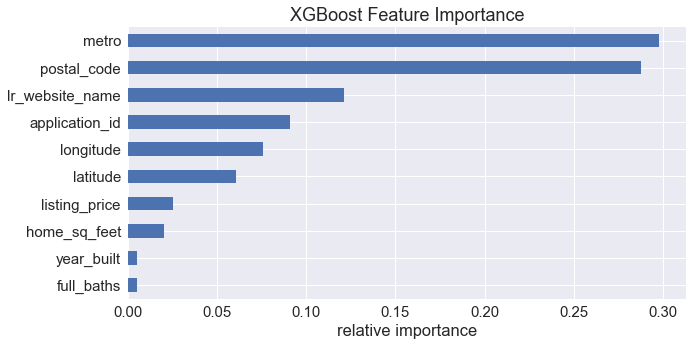

In [29]:
model.plot_importance()

In [30]:
pred = model.predict(X_test)

In [31]:
np.mean(pred)

0.37966333141026398

In [32]:
np.median(pred)

0.40416857706964077

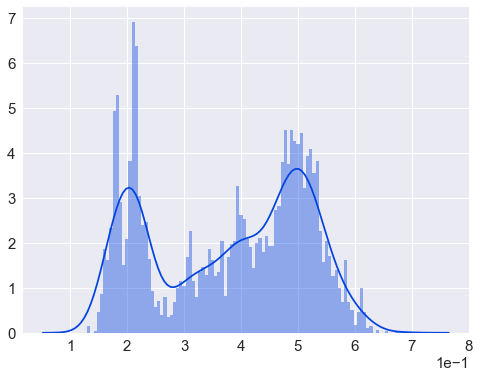

In [33]:
pl.distro(pred)

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred)

0.72398242368177601

# make decision

In [35]:
print("Zap lead(%): ", sum(y_test)*100 / y_test.shape)

Zap lead(%):  [ 13.0867144]


In [36]:
# Take a random sample
rand_sample = y_test.sample(frac=0.50)

print("Zap lead(%) in random sample: ", sum(rand_sample)*100 / rand_sample.shape)

Zap lead(%) in random sample:  [ 12.64916468]


In [37]:
# select 50% of the data with high probability
threshold = np.percentile(pred, 50)
index = [True if x>threshold else False for x in pred]

In [38]:
prob_sample = y_test[index]
print("Zap lead(%) in sample with high probability: ", sum(prob_sample)*100 / prob_sample.shape)

Zap lead(%) in sample with high probability:  [ 21.10712863]


In [39]:
# select 50% of the data with low probability
threshold = np.percentile(pred, 50)
index = [True if x<threshold else False for x in pred]
prob_sample = y_test[index]
print("Zap lead(%) in sample with low probability: ", sum(prob_sample)*100 / prob_sample.shape)

Zap lead(%) in sample with low probability:  [ 4.98405104]
